In [1]:
import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from numba import jit
import matplotlib.lines as mlines  # For creating custom legend entries
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle
import seaborn as sns
import os

sns.set_context("paper")
sns.set_palette("colorblind")
sns.set(style="whitegrid", font_scale=2)

plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True

In [2]:
np.random.seed(42)

In [3]:
# Define your parameters
topology = 'star'
U = 50 # Number of Users (int)
A = 1000.0  # Area size in meters (float)
F = 0.7 # Fraction of the moving users (float)
B = 40 # Number of Buildings (int)
T = 18000.0 # Simulation time in seconds (float)
chunk_size = 7 #number of measurments per UE (same as number of UAVs) (int)


folder_name = f"{topology}-U{U}-A{A}-F{F}-B{B}-T{T}"
simulation_results_path = os.path.join('..', 'ns3-install', 'ns-3-dev', 'simulation_results')

In [4]:
# Load and process the Q-tensor that contains the quality metrics between drones and users
# The tensor has dimensions: (time_steps, drones, users)
# Each element q[t,d,u] represents the connection quality between drone d and user u at time t
q_tensor_path = os.path.join(simulation_results_path, folder_name, f'{folder_name}-q-tensor.npy')
q_tensor = np.load(q_tensor_path)

# Transpose the tensor to have dimensions in the order: (time_steps, drones, users)
# Original order was (time_steps, users, drones)
q_tensor = np.transpose(q_tensor, (0, 2, 1))

# Get tensor dimensions and print them for verification
q_tensor_shape = q_tensor.shape
print(f"Time steps: {q_tensor_shape[0]}\nDrones: {q_tensor_shape[1]}\nUsers: {q_tensor_shape[2]}")

Time steps: 89998
Drones: 7
Users: 50


In [5]:
buildings_df = pd.read_csv(os.path.join(simulation_results_path, folder_name, f'{folder_name}-buildings.csv'))
ue_positions = pd.read_csv(os.path.join(simulation_results_path, folder_name, f'{folder_name}-ue_positions.csv'))
enb_positions = pd.read_csv(os.path.join(simulation_results_path, folder_name, f'{folder_name}-enb_positions.csv'))

In [6]:
Emax = 100 * 3600 #watt second
N = q_tensor_shape[1]
M = q_tensor_shape[2]
tau = 0.2 #second
max_time_slots = 89000
P_P = 20 #watt
P_laser = 10
zeta = 0.8
epsilon = 0.01
alpha = 1
beta = 1 - alpha # Weight factor for traffic load
eta = 0.15
e_p = 1.28 * 10e-19
n_p = 100

/tmp/ipykernel_2598242/939721727.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(os.path.join(simulation_results_path, folder_name, f'{folder_name}-rem-example'), delim_whitespace=True, header=None, names=["x", "y", "z", "value"])


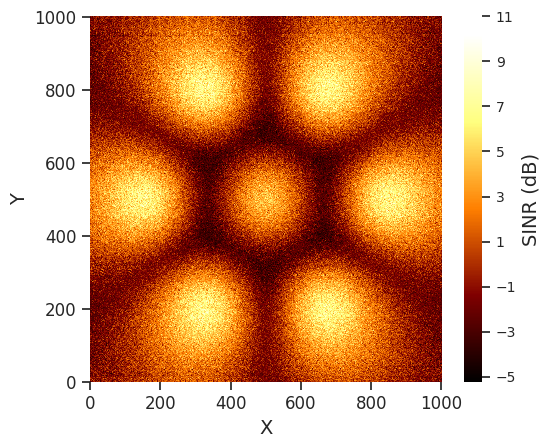

In [7]:
# Load and process SINR data from REM file
df = pd.read_csv(os.path.join(simulation_results_path, folder_name, f'{folder_name}-rem-example'), delim_whitespace=True, header=None, names=["x", "y", "z", "value"])

# Convert SINR to dB and create grid for heatmap
df["value"] = 10 * np.log10(df["value"])
pivot_table = df.pivot_table(index="y", columns="x", values="value")

# Create heatmap plot
plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    pivot_table, cmap="afmhot", cbar=True, 
    yticklabels=False, xticklabels=False, 
    cbar_kws={'label': 'SINR (dB)'}
)
plt.gca().invert_yaxis()

# Configure axis ticks and labels
max_value = max(pivot_table.columns.max(), pivot_table.index.max())
tick_locations = np.arange(0, max_value + 1, 200)

plt.xticks(
    np.interp(tick_locations, pivot_table.columns, range(len(pivot_table.columns))),
    tick_locations.astype(int), 
    rotation=0, fontsize=12
)
plt.yticks(
    np.interp(tick_locations, pivot_table.index, range(len(pivot_table.index))),
    tick_locations.astype(int), 
    fontsize=12
)

# Configure colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(-5, 12, 2))
cbar.ax.tick_params(labelsize=10)

# Set labels and finalize plot
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
cbar.set_label("SINR (dB)", fontsize=14)
plt.grid(False)
plt.tight_layout()

plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}-REM.png'), 
            dpi=600, format='png', bbox_inches='tight', pad_inches=0, transparent=True)

/tmp/ipykernel_2593714/2072444339.py:76: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=1.0)
/tmp/ipykernel_2593714/2072444339.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


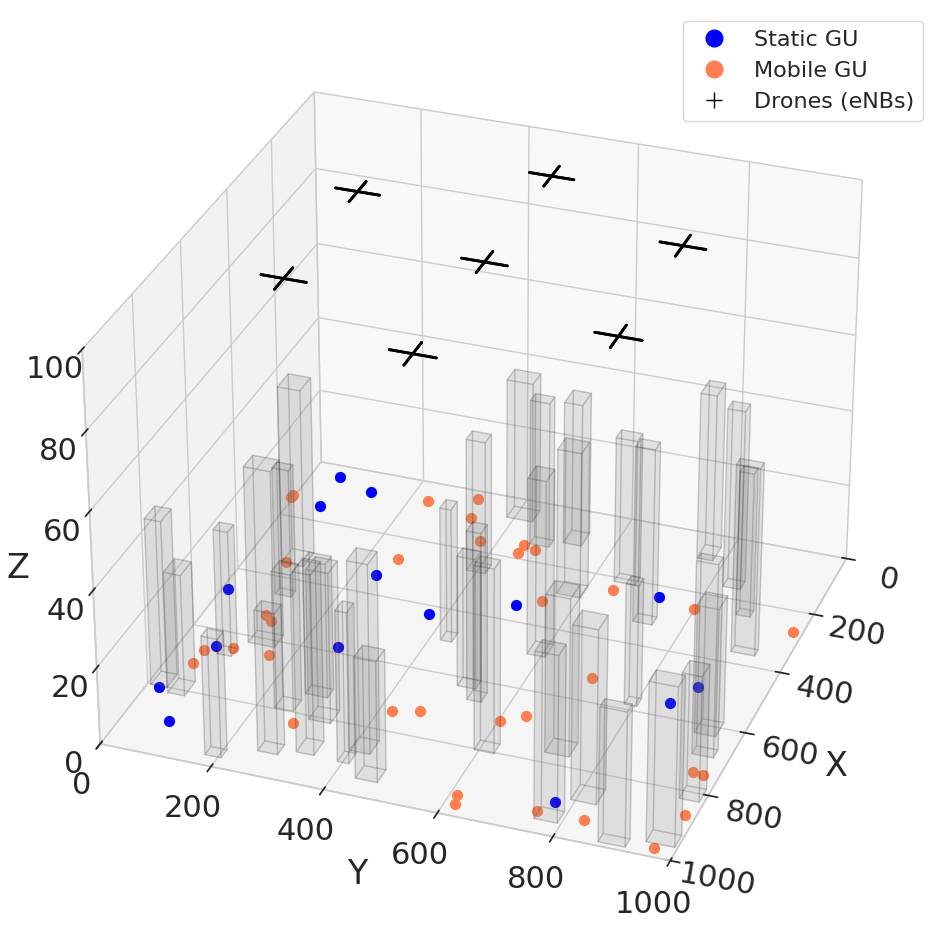

In [15]:
# Create 3D visualization of the environment
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=20)

cross_size = 40  # Size of cross markers for drones

# Plot buildings as semi-transparent 3D cubes
for i, row in buildings_df.iterrows():
    x_range = [row['X_Min'], row['X_Max'], row['X_Max'], row['X_Min'], row['X_Min']]
    y_range = [row['Y_Min'], row['Y_Min'], row['Y_Max'], row['Y_Max'], row['Y_Min']]
    z_min = 0
    z_max = row['Z_Max']
    
    # Create vertices for all building faces
    vertices = [
        list(zip(x_range, y_range, [z_min]*5)),  # Bottom
        list(zip(x_range, y_range, [z_max]*5)),  # Top
        [(x_range[0], y_range[0], z_min), (x_range[1], y_range[1], z_min), 
         (x_range[1], y_range[1], z_max), (x_range[0], y_range[0], z_max)],  # Front
        [(x_range[1], y_range[1], z_min), (x_range[2], y_range[2], z_min),
         (x_range[2], y_range[2], z_max), (x_range[1], y_range[1], z_max)],  # Right
        [(x_range[2], y_range[2], z_min), (x_range[3], y_range[3], z_min),
         (x_range[3], y_range[3], z_max), (x_range[2], y_range[2], z_max)],  # Back
        [(x_range[3], y_range[3], z_min), (x_range[0], y_range[0], z_min),
         (x_range[0], y_range[0], z_max), (x_range[3], y_range[3], z_max)]   # Left
    ]
    
    poly3d = Poly3DCollection(vertices, color='gray', alpha=0.1, edgecolor='black')
    ax.add_collection3d(poly3d)

# Plot ground users (static in blue, mobile in coral)
ue_first_positions = ue_positions.groupby('IMSI').first()
for i, (ue_id, ue_data) in enumerate(ue_first_positions.iterrows()):
    is_static = ue_positions[ue_positions['IMSI'] == ue_id][['X Position', 'Y Position']].nunique().sum() == 2
    color = 'blue' if is_static else 'coral'
    label = 'Static GU' if (is_static and i == 0) else 'Mobile GU' if (not is_static and i == 0) else ""
    ax.scatter(ue_data['X Position'], ue_data['Y Position'], 1.5, color=color, label=label, s=50)

# Plot drones with cross markers
for i, row in enb_positions.iterrows():
    ax.plot([row['X Position'] - cross_size, row['X Position'] + cross_size], 
            [row['Y Position'], row['Y Position']], [100, 100], color='black', lw=2)
    ax.plot([row['X Position'], row['X Position']], 
            [row['Y Position'] - cross_size, row['Y Position'] + cross_size], [100, 100], color='black', lw=2)

# Configure plot settings
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)
ax.set_zlim(0, 100)

# Adjust tick labels and positions
ax.tick_params(axis='x', rotation=-10, pad=20, labelright=False, labelleft=True)
ax.tick_params(axis='y', rotation=0, pad=20, labelright=False, labelleft=True)
[t.set_ha('center') for t in ax.get_xticklabels()]
[t.set_va('bottom') for t in ax.get_xticklabels()]
[t.set_ha('center') for t in ax.get_yticklabels()]
[t.set_va('bottom') for t in ax.get_yticklabels()]

ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_yticks([0, 200, 400, 600, 800, 1000])

# Set axis labels with padding
ax.set_xlabel('X', labelpad=25)
ax.set_ylabel('Y', labelpad=15)
ax.set_zlabel('Z', labelpad=10)

# Add legend
legend_elements = [
    mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=12, label='Static GU'),
    mlines.Line2D([], [], color='coral', marker='o', linestyle='None', markersize=12, label='Mobile GU'),
    mlines.Line2D([], [], color='black', marker='+', linestyle='None', markersize=12, label='Drones (eNBs)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=16)

plt.tight_layout(pad=1.0)
plt.tight_layout()
# plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}-3d_user_plot.png'), dpi=600, format='png', transparent=True)
plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}-3d_user_plot.pdf'), 
            dpi=600, format='pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
energy = np.random.randint(0.9*Emax, Emax + 1, size=N)
energy_array = np.zeros((N, max_time_slots))
energy_array[:, 0] = energy

RUN this only if you want to replicate the results, otherwise load the saved simulation results from the next cell

In [ ]:
# Define traffic types and their probabilities
traffic_types = ['voice_call', 'real_time_streaming', 'file_transfer'] 
traffic_probabilities = [0.6, 0.1, 0.3]  # Voice calls most common, streaming least common

# Randomly assign traffic types to users based on probabilities
user_traffic_types = np.random.choice(traffic_types, M, p=traffic_probabilities)

# Data rate ranges (kbps) for each traffic type
data_rate_ranges = {
    'voice_call': (8, 64),               # Low constant rate for voice
    'real_time_streaming': (300, 5000),  # Medium-high rate for streaming
    'file_transfer': (1000, 20000)       # High bursty rate for downloads
}

# Initialize data rates for all users across time slots
data_rate_tensor = np.zeros((max_time_slots, M))

# Generate data rates based on each user's traffic type
for user_idx, traffic_type in enumerate(user_traffic_types):
    min_rate, max_rate = data_rate_ranges[traffic_type]
    
    if traffic_type == 'voice_call':
        # Constant rate for voice calls
        data_rate_tensor[:, user_idx] = np.random.uniform(min_rate, max_rate)
    
    elif traffic_type == 'real_time_streaming':
        # Variable rate for streaming
        data_rate_tensor[:, user_idx] = np.random.uniform(min_rate, max_rate, max_time_slots)
    
    else:  # file_transfer
        # Bursty traffic with 50% active time
        burst_pattern = np.random.binomial(1, 0.5, max_time_slots)
        burst_data_rates = np.random.uniform(min_rate, max_rate, max_time_slots)
        data_rate_tensor[:, user_idx] = burst_pattern * burst_data_rates

data_rate_tensor = data_rate_tensor * tau

# Initialize tracking arrays for simulation
priority_tensor = np.random.rand(max_time_slots, M)
charging_history = np.zeros((N, max_time_slots))
C_values = np.zeros((N, M, max_time_slots))
users_per_drone = np.zeros((max_time_slots, N))
charging_allowed = True
charging_window_count = np.zeros(N)
accumulated_traffic_per_drone = np.zeros((max_time_slots, N))
rho_values = np.zeros((max_time_slots, N))
last_active_time_slot = None
weighted_scores_arr = np.zeros((max_time_slots, N))

# Track traffic by priority level
low_traffic_accumulated = np.zeros((max_time_slots, N))
medium_traffic_accumulated = np.zeros((max_time_slots, N))
high_traffic_accumulated = np.zeros((max_time_slots, N))

# Main simulation loop over time slots
for t in range(max_time_slots):
    # Get connectivity matrix for current time slot
    if t < q_tensor.shape[0]:
        q = q_tensor[t]
    else:
        break

    # First optimization: Maximize network connectivity
    connectivity_problem = pulp.LpProblem(f"Maximize_Network_Active_Time_Slot_{t+1}", pulp.LpMaximize)
    
    # Decision variables
    C = pulp.LpVariable.dicts("C", (range(N), range(M)), cat='Binary')
    S = pulp.LpVariable(f"S_{t+1}", cat='Binary')

    # Maximize active time slot and connections
    total_connections = pulp.lpSum(C[i][j] for i in range(N) for j in range(M))
    connectivity_problem += S + total_connections * epsilon

    # Add connectivity constraints
    for i in range(N):
        for j in range(M):
            if energy_array[i][t] <= 10 * 3600:
                connectivity_problem += C[i][j] == 0
            else:
                connectivity_problem += C[i][j] <= q[i, j]

    # Each user connects to at most one drone
    for j in range(M):
        connectivity_problem += pulp.lpSum(C[i][j] for i in range(N)) <= 1

    # Active time slot constraints
    active_users_constraint = pulp.lpSum(C[i][j] for i in range(N) for j in range(M))
    zeta_threshold = zeta * M
    connectivity_problem += active_users_constraint >= zeta_threshold - (1 - S) * M
    connectivity_problem += active_users_constraint <= S * M

    # Solve connectivity optimization
    connectivity_problem.solve(pulp.PULP_CBC_CMD(msg=False))

    # Check if network is still active
    S_value = pulp.value(S)
    if S_value == 0:
        charging_allowed = False
        last_active_time_slot = t
        
        # Zero out remaining energy
        for future_t in range(t + 1, max_time_slots):
            energy_array[:, future_t] = 0
        break

    last_active_time_slot = t + 1

    # Track connected users per drone
    for i in range(N):
        users_per_drone[t, i] = sum(C[i][j].varValue for j in range(M))

    # Second optimization: Charging and traffic management
    traffic_loads = np.zeros(N)
    for i in range(N):
        for j in range(M):
            if pulp.value(C[i][j]) > 0.5:
                traffic_value = data_rate_tensor[t, j]
                accumulated_traffic_per_drone[t, i] += traffic_value
                traffic_loads[i] += traffic_value
                
                # Categorize traffic by volume
                if traffic_value <= 0.3:
                    low_traffic_accumulated[t, i] += traffic_value
                elif traffic_value <= 0.6:
                    medium_traffic_accumulated[t, i] += traffic_value
                else:
                    high_traffic_accumulated[t, i] += traffic_value

    # Store connection values
    for i in range(N):
        for j in range(M):
            C_values[i, j, t] = pulp.value(C[i][j])

    # Skip charging if no laser power
    if P_laser == 0:
        charging_history[:, t] = 0
        if t + 1 < max_time_slots:
            energy_array[:, t + 1] = np.maximum(0, energy_array[:, t] - (P_P * tau))
        continue

    # Optimize charging if allowed
    elif charging_allowed:
        # Calculate charging scores
        weighted_scores = []
        for i in range(N):
            N_i_t = users_per_drone[t, i]
            E_i_t = energy_array[i, t]
            w_i_t = alpha * (1 - E_i_t / np.max(energy_array)) + (beta) * ((traffic_loads[i]/np.max(traffic_loads)))
            weighted_scores.append(w_i_t)
            weighted_scores_arr[t, i] = alpha * (1 - E_i_t / Emax) + beta * (traffic_loads[i] / np.max(traffic_loads))

        # Setup charging optimization
        charging_problem = pulp.LpProblem(f"Charging_Optimization_Time_Slot_{t+1}", pulp.LpMaximize)
        b = pulp.LpVariable.dicts("b", range(N), cat='Binary')
        
        # Maximize weighted charging score
        charging_problem += pulp.lpSum(weighted_scores[i] * b[i] for i in range(N))
        
        # Only one drone can charge per slot
        charging_problem += pulp.lpSum(b[i] for i in range(N)) <= 1
        
        # No charging for depleted drones
        for i in range(N):
            if energy_array[i, t] <= 10 * 3600:
                charging_problem += b[i] == 0

        # Solve charging optimization
        charging_problem.solve(pulp.PULP_CBC_CMD(msg=False))

        # Record charging decisions
        for i in range(N):
            charging_history[i, t] = pulp.value(b[i])

        # Update energy levels for next time slot
        if t + 1 < max_time_slots:
            for i in range(N):
                if charging_history[i, t] == 1:
                    if beta >= 0:
                        # Calculate power needed for traffic offload
                        P_traffic = (accumulated_traffic_per_drone[t, i] * e_p * n_p) / (tau * eta)
                        P_traffic = min(P_traffic, P_laser)
                        
                        # Remaining power for charging
                        P_energy = P_laser - P_traffic
                        rho_values[t, i] = P_energy / P_laser
                        
                        # Update drone energy
                        energy_array[i, t + 1] = np.minimum(Emax, np.maximum(0, energy_array[i, t] - (P_P * tau) + (P_energy *tau)))
                else:
                    # Normal energy depletion
                    energy_array[i, t + 1] = np.maximum(0, energy_array[i, t] - (P_P * tau))


In [ ]:
print(f"last active time slot for alpha= {alpha} and beta= {beta} is : {last_active_time_slot}")

last active time slot for alpha= 0.4 and beta= 0.6 is : 78925


Uncomment if you want to save new optimisation results

In [ ]:

# # Example: Save tensors and matrices
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_data_rate_tensor_b{alpha}.npy'), data_rate_tensor)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_priority_tensor_b{alpha}.npy'), priority_tensor)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_charging_history_b{alpha}.npy'), charging_history)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_C_values_b{alpha}.npy'), C_values)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_users_per_drone_b{alpha}.npy'), users_per_drone)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_accumulated_traffic_per_drone_b{alpha}.npy'), accumulated_traffic_per_drone)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_rho_values_b{alpha}.npy'), rho_values)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_weighted_scores_arr_b{alpha}.npy'), weighted_scores_arr)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_energy_arr_b{alpha}.npy'), energy_array)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_low_traffic_accumulated_b{alpha}.npy'), low_traffic_accumulated)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_medium_traffic_accumulated_b{alpha}.npy'), medium_traffic_accumulated)
# np.save(os.path.join(simulation_results_path, folder_name, f'{folder_name}_high_traffic_accumulated_b{alpha}.npy'), high_traffic_accumulated)


In [16]:
energy_array = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_energy_arr_b{alpha}.npy'))
data_rate_tensor = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_data_rate_tensor_b{alpha}.npy'))
priority_tensor = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_priority_tensor_b{alpha}.npy'))
charging_history = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_charging_history_b{alpha}.npy'))
C_values = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_C_values_b{alpha}.npy'))
users_per_drone = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_users_per_drone_b{alpha}.npy'))
accumulated_traffic_per_drone = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_accumulated_traffic_per_drone_b{alpha}.npy'))
rho_values = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_rho_values_b{alpha}.npy'))
weighted_scores_arr = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_weighted_scores_arr_b{alpha}.npy'))
low_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_low_traffic_accumulated_b{alpha}.npy'))
medium_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_medium_traffic_accumulated_b{alpha}.npy'))
high_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_high_traffic_accumulated_b{alpha}.npy'))

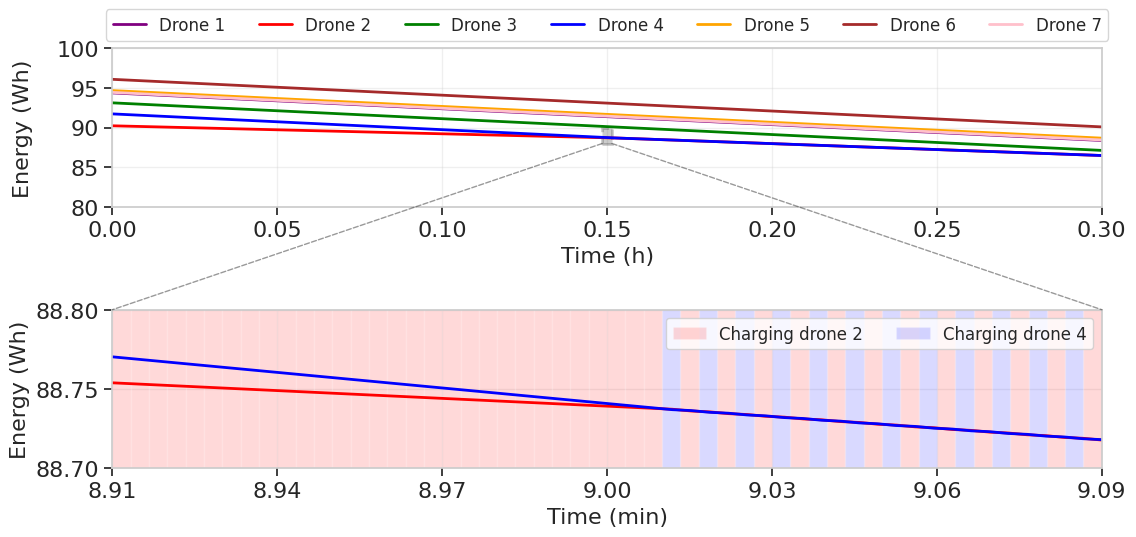

In [18]:
# Plot configuration for energy usage and charging visualization
time_slot_duration_seconds = 0.2
time_slot_duration_hours = time_slot_duration_seconds / 3600
start_hour, end_hour = 0, 0.3
drone_indices = list(range(7))
colors = ['purple', 'red', 'green', 'blue', 'orange', 'brown', 'pink', 'gray']

# Convert time units
start_slot = int(start_hour * 3600 / time_slot_duration_seconds)
end_slot = int(end_hour * 3600 / time_slot_duration_seconds)
energy_array_hours = energy_array[:, start_slot:end_slot + 1] / 3600
time_labels_hours = np.arange(start_slot, end_slot + 1) * time_slot_duration_hours

# Create main figure with two subplots
fig, (top, middle) = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 2]})
fig.subplots_adjust(hspace=0.4)

# Top subplot: Energy usage over time for all drones
top.set_xlabel('Time (h)', fontsize=16)
top.set_ylabel('Energy (Wh)', fontsize=16, labelpad=20)
top.yaxis.set_label_coords(-0.08, 0.5)
top.set_ylim(80, 100)
top.set_xticks(np.arange(start_hour, end_hour + 0.01, 0.05))
top.set_yticks(np.arange(80, 101, 5))
top.tick_params(axis='both', labelsize=16)
top.grid(True, which='both', alpha=0.3)
top.set_xlim(start_hour, end_hour)

for i, drone_idx in enumerate(drone_indices):
    top.plot(time_labels_hours, energy_array_hours[drone_idx, :],
             label=f"Drone {drone_idx + 1}", linestyle='-', linewidth=2, color=colors[i % len(colors)])

top.legend(loc='upper center', fontsize=12, ncol=len(drone_indices), bbox_to_anchor=(0.5, 1.3))

# Middle subplot: Zoomed view of charging events
zoom_start, zoom_end = 0.1485, 0.1515
zoom_start_slot = int(zoom_start * 3600 / time_slot_duration_seconds)
zoom_end_slot = int(zoom_end * 3600 / time_slot_duration_seconds)
time_points_zoom = np.arange(zoom_start_slot, zoom_end_slot + 1) * time_slot_duration_hours

# Plot charging status bars
bar_height = 1
for drone_idx in drone_indices:
    charging_data = charging_history[drone_idx, zoom_start_slot:zoom_end_slot + 1]
    
    if any(charging_data):
        middle.bar(0, 0, color=colors[drone_idx], alpha=0.15, 
                  label=f"Charging drone {drone_idx + 1}")
    
    for t_idx in range(len(time_points_zoom)):
        if charging_data[t_idx] == 1:
            middle.bar(time_points_zoom[t_idx], bar_height,
                      width=time_slot_duration_hours, bottom=88.5,
                      color=colors[drone_idx], alpha=0.15, align='edge')

# Plot energy lines for selected drones in zoom view
selected_drones = [1, 2, 3]
selected_colors = ['red', 'green', 'blue']
for i, drone_idx in enumerate(selected_drones):
    zoom_data = energy_array_hours[drone_idx, zoom_start_slot:zoom_end_slot + 1]
    plot_times = np.linspace(zoom_start, zoom_end, len(zoom_data))
    middle.plot(plot_times, zoom_data, linestyle='-', linewidth=2, color=selected_colors[i])

# Configure middle subplot
middle.set_xlabel('Time (min)', fontsize=16)
middle.set_ylabel('Energy (Wh)', fontsize=16)
middle.set_ylim(88.7, 88.8)
middle.set_xlim(zoom_start, zoom_end)
minute_ticks = np.arange(zoom_start * 60, zoom_end * 60 + 0.01, 0.03)
middle.set_xticks(minute_ticks / 60)
middle.set_xticklabels([f'{x:.2f}' for x in minute_ticks])
middle.set_yticks(np.arange(88.7, 88.81, 0.05))
middle.grid(True, which='both', alpha=0.3)
middle.tick_params(axis='both', labelsize=16)
middle.legend(loc='upper right', fontsize=12, ncol=len(selected_drones), bbox_to_anchor=(1, 1))

# Add zoom region highlight and connectors
top.add_patch(Rectangle((zoom_start, 88), zoom_end - zoom_start, 2,
                        facecolor='black', alpha=0.2, edgecolor='black', linestyle='--', linewidth=2))

y_top_of_middle = middle.get_ylim()[1]
fig.add_artist(ConnectionPatch(xyA=(zoom_start, 88), coordsA=top.transData,
                               xyB=(zoom_start, y_top_of_middle), coordsB=middle.transData,
                               color='black', linestyle='--', linewidth=1, alpha=0.4))
fig.add_artist(ConnectionPatch(xyA=(zoom_end, 88), coordsA=top.transData,
                               xyB=(zoom_end, y_top_of_middle), coordsB=middle.transData,
                               color='black', linestyle='--', linewidth=1, alpha=0.4))

plt.tight_layout()
# plt.savefig(os.path.join(simulation_results_path, folder_name, f"{folder_name}_energy_depltion_and_charging.png"), dpi=600, format='png', transparent=True)
plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}_energy_depltion_and_charging.pdf'), 
            dpi=600, format='pdf', bbox_inches='tight', pad_inches=0)


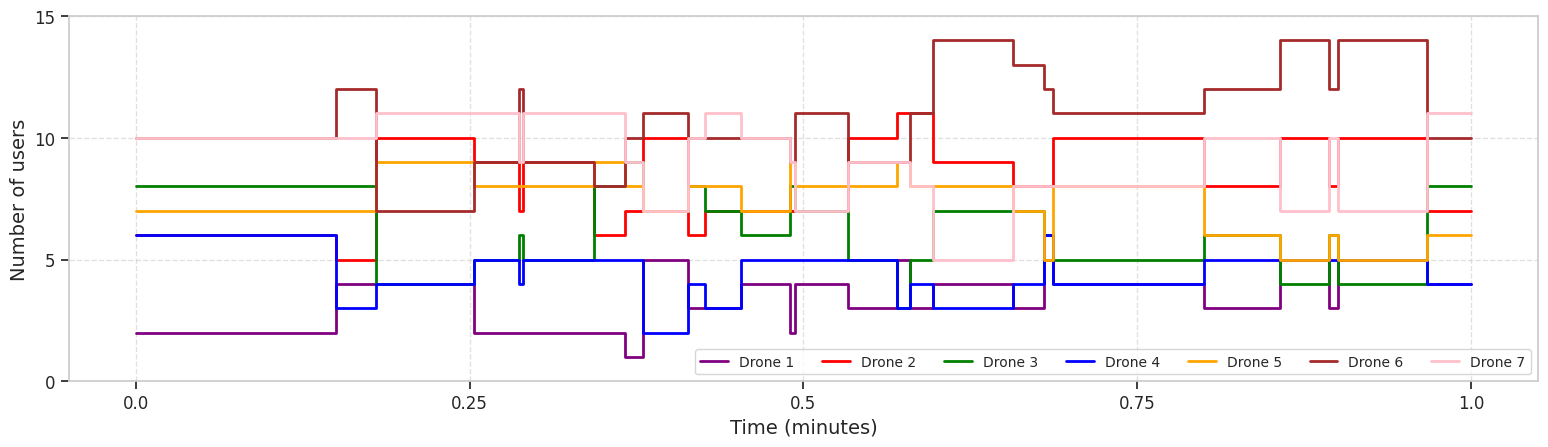

In [15]:
# Plot user distribution over first hour for selected drones
logging_interval = 0.2  # Time between logged slots (seconds) 
time_values = np.arange(users_per_drone.shape[0]) * logging_interval
selected_drones = [0, 1, 2, 3, 4, 5, 6]  # Drones to plot (0-based indices)

# Filter to first hour of data
first_hour_limit = 60  # seconds
first_hour_indices = time_values <= first_hour_limit
time_values_first_hour = time_values[first_hour_indices]
users_first_hour = [users_per_drone[first_hour_indices, drone] for drone in selected_drones]

# Create line plot
plt.figure(figsize=(16, 5))
colors = ['purple', 'red', 'green', 'blue', 'orange', 'brown', 'pink', 'gray']

for idx, (drone_data, color) in enumerate(zip(users_first_hour, colors)):
    plt.step(
        time_values_first_hour / 60,  # Convert to minutes
        drone_data,
        label=f"Drone {selected_drones[idx] + 1}",
        color=color,
        linewidth=2
    )

# Configure plot
plt.xlabel("Time (minutes)", fontsize=14)
plt.ylabel("Number of users", fontsize=14)

tick_positions = np.linspace(0, first_hour_limit, 5)
tick_labels = (tick_positions / 60).round(2)
plt.xticks(ticks=tick_positions / 60, labels=tick_labels, fontsize=12)
plt.yticks(np.arange(0, np.max(users_first_hour)+ 6, 5), fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="lower right", ncol=7)

plt.tight_layout()
plt.show()

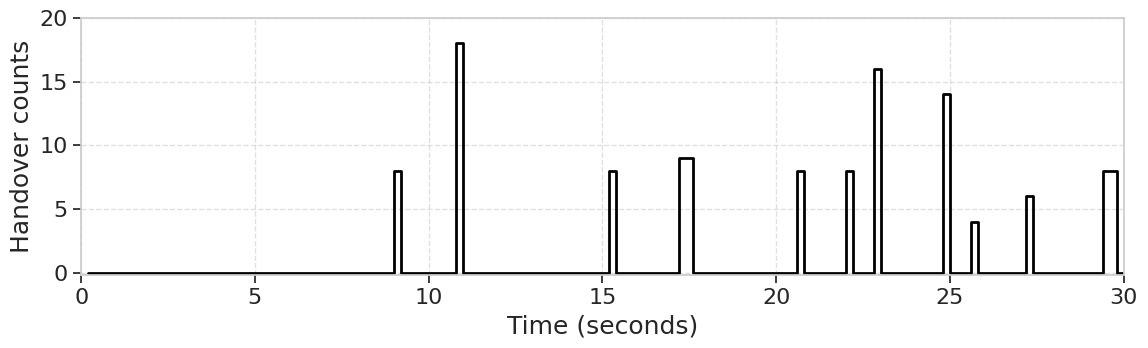

In [20]:
def plot_handover_events(users_per_drone, logging_interval, time_limit, save_path=False):
    """
    Plots handover events over time to visualize user transitions between drones.
    
    Args:
        users_per_drone: Array of user counts per drone over time
        logging_interval: Time between data points in seconds
        time_limit: Maximum time to plot in seconds
        save_path: Optional path to save plot as PNG
    """
    # Set plot parameters
    x_tick_interval = 5  
    y_max = 20
    y_tick_interval = 5

    # Process time data
    time_stamps = np.arange(users_per_drone.shape[0]) * logging_interval
    time_mask = time_stamps <= time_limit
    time_stamps_filtered = time_stamps[time_mask]
    user_counts_filtered = users_per_drone[time_mask, :]

    # Calculate handover events between consecutive time steps
    handover_events = np.sum(np.abs(np.diff(user_counts_filtered, axis=0)), axis=1)

    # Create plot
    plt.figure(figsize=(12, 4))
    plt.step(time_stamps_filtered[1:], handover_events, linestyle='-', linewidth=2, color='black')
    
    plt.xlabel("Time (seconds)", fontsize=18)
    plt.ylabel("Handover counts", fontsize=18)
    plt.xticks(ticks=np.arange(0, time_limit + 1, x_tick_interval), fontsize=16)
    plt.yticks(np.arange(0, y_max + 1, y_tick_interval), fontsize=16)
    plt.xlim(0, min(time_limit, time_stamps_filtered[-1]))
    plt.ylim(-0.2, y_max)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    if save_path:
        # plt.savefig(save_path, dpi=600, bbox_inches='tight', format='png', transparent=True)
        plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}_handover_counts.pdf'), 
            dpi=600, format='pdf', bbox_inches='tight', pad_inches=0)
    else:
        plt.show()

plot_handover_events(users_per_drone, logging_interval=0.2, time_limit=30, save_path=True)

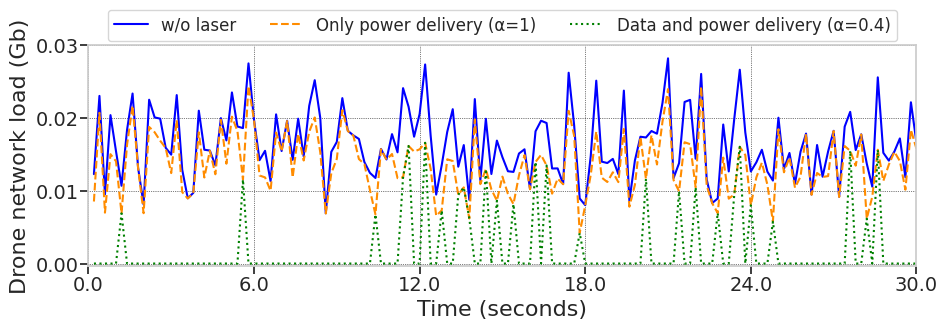

In [22]:
# Uncomment for traffic plots

alpha = 1
alpha_beta = 0.4

energy_array = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_energy_arr_b{alpha}.npy'))
data_rate_tensor = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_data_rate_tensor_b{alpha}.npy'))
priority_tensor = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_priority_tensor_b{alpha}.npy'))
charging_history = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_charging_history_b{alpha}.npy'))
C_values = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_C_values_b{alpha}.npy'))
users_per_drone = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_users_per_drone_b{alpha}.npy'))
accumulated_traffic_per_drone = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_accumulated_traffic_per_drone_b{alpha}.npy'))
rho_values = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_rho_values_b{alpha}.npy'))
weighted_scores_arr = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_weighted_scores_arr_b{alpha}.npy'))
low_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_low_traffic_accumulated_b{alpha}.npy'))
medium_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_medium_traffic_accumulated_b{alpha}.npy'))
high_traffic_accumulated = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_high_traffic_accumulated_b{alpha}.npy'))


# Laser transfer rate calculation
laser_transfer_rate = ((P_laser * eta * tau) / (1.28 * 10e-17)) * 1e-6  # bits and tau must be in seconds

# Load charging histories
charging_history_b1 = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_charging_history_b{alpha}.npy'))
charging_history_b_alpha = np.load(os.path.join(simulation_results_path, folder_name, f'{folder_name}_charging_history_b{alpha_beta}.npy'))

# Get laser targets
laser_target_b1 = np.argmax(charging_history_b1, axis=0)
laser_target_b_alpha = np.argmax(charging_history_b_alpha, axis=0)

# Calculate total accumulated traffic across all drones
total_accumulated_traffic = np.sum(accumulated_traffic_per_drone[:250, :], axis=1) * 1e-6  # In Gb

# Initialize modified traffic arrays
total_modified_traffic_b1 = total_accumulated_traffic.copy()
total_modified_traffic_b_alpha = total_accumulated_traffic.copy()

# Calculate laser transfer rates
laser_transfer_rate_b1 = ((P_laser * eta * tau) / (1.28 * 10e-17)) * 1e-6
laser_transfer_rate_b_alpha = ((P_laser * eta * tau) / (1.28 * 10e-17)) * 1e-6

# Adjust traffic for alpha1
for t in range(250):
    for i in range(N):
        if laser_target_b1[t] == i:
            effective_transfer_rate = laser_transfer_rate_b1 * (1 - rho_values[t, i])
            total_modified_traffic_b1[t] -= effective_transfer_rate
            total_modified_traffic_b1[t] = max(0, total_modified_traffic_b1[t])

# Adjust traffic for alpha_alpha
for t in range(250):
    for i in range(N):
        if laser_target_b_alpha[t] == i:
            effective_transfer_rate = laser_transfer_rate_b_alpha * (1 - rho_values[t, i])
            total_modified_traffic_b_alpha[t] -= effective_transfer_rate
            total_modified_traffic_b_alpha[t] = max(0, total_modified_traffic_b_alpha[t])

# Convert time to seconds
time_in_hours = np.array(range(1, 250 + 1)) * 0.2 / 3600
time_in_seconds = time_in_hours * 3600  # Convert hours directly to seconds

# Define time range in seconds
start_second = 0              # Start at 0 seconds
end_second = 30   # 0.006 hours = 21.6 seconds

# Create mask for the time range
time_mask = (time_in_seconds >= start_second) & (time_in_seconds <= end_second)

# Apply the mask to both time and data
plot_time_seconds = time_in_seconds[time_mask]
plot_accumulated_traffic = total_accumulated_traffic[time_mask]
plot_modified_traffic_b1 = total_modified_traffic_b1[time_mask]
plot_modified_traffic_b_alpha = total_modified_traffic_b_alpha[time_mask]

# Create the figure
plt.figure(figsize=(10, 4))

# Plot using the masked data
accumulated_traffic_line, = plt.plot(plot_time_seconds, plot_accumulated_traffic, 
                                   label='w/o laser', color='blue')

modified_traffic_b1_line, = plt.plot(plot_time_seconds, plot_modified_traffic_b1, 
                                    label=f'Only power delivery (α={alpha})', 
                                    color='darkorange', linestyle='--')

modified_traffic_b_alpha_line, = plt.plot(plot_time_seconds, plot_modified_traffic_b_alpha, 
                                        label=f'Data and power delivery (α={alpha_beta})', 
                                        color='green', linestyle=':')

# Calculate average values for the selected range
avg_total_accumulated_traffic = np.mean(plot_accumulated_traffic)
avg_total_modified_traffic_b1 = np.mean(plot_modified_traffic_b1)
avg_total_modified_traffic_b_alpha = np.mean(plot_modified_traffic_b_alpha)

# Set labels and title
plt.ylabel('Drone network load (Gb)', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=16)  # Updated to seconds

# Create legend below the x-axis label
plt.legend(loc='upper center',
          bbox_to_anchor=(0.5, 1.2),
          ncol=3,
          fontsize=12)

# Add grid
plt.grid(True, which='both', axis='both', linestyle=':', linewidth=0.5, color='black')

# Set x-ticks in seconds (6 evenly spaced ticks)
x_ticks = np.linspace(start_second, end_second, 6)
plt.xticks(x_ticks, rotation=0, fontsize=14)
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Set y-ticks
plt.yticks(ticks=np.arange(0, 0.04, 0.01), rotation=0, fontsize=14)

# Adjust tick parameters
plt.gca().tick_params(axis='x', which='major', pad=1)
plt.gca().tick_params(axis='y', which='major', pad=1)

plt.ylim(-0.0003, 0.03)
plt.xlim(0.0, 30)
# Tight layout
plt.tight_layout()

# Save the figure
# plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}_traffic_comparison.png'), dpi=600, format='png', transparent=True)
plt.savefig(os.path.join(simulation_results_path, folder_name, f'{folder_name}_traffic_comparison.pdf'), 
            dpi=600, format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()